# Simulated Data

We study the performance of Hamiltonian Monte Carlo and Stochastic Gradient Hamiltonian Monte Carlo for classification tasks. 



# Binary Classification

First, a 2-dimensional binary classification problem is simulated. Data is generated from two well separated clusters, so a linear classification model is well suited. The generated data is split into train and test datasets. 

In [1]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

D=2
centers = [[-5, 0],  [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, cluster_std=1,random_state=40)
X = (X - X.mean(axis=0)) / X.std(axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

A logistic regression model is fitted using the 2-dimensional features and $L_2$ regularization with $\alpha=0.25$. The weights and bias are initialized with $\mathbf w=0$ and $b=0$. Stochastic Gradient descent is also used to estimate the parameters using $10e4$ epochs, a learning rate $\epsilon=1e-5$ and a batch size $b=50$.

In [2]:
import sys
sys.path.append("../") 
import hamiltonian.logistic as logistic
import numpy as np

alpha=1./4.
start_p={'weights':np.zeros(D),'bias':np.zeros(1)}
hyper_p={'alpha':alpha}

par,loss=logistic.sgd(X_train,y_train,start_p,hyper_p,eta=1e-5,epochs=1e4,batch_size=50,verbose=True)
y_pred=logistic.predict(X_test,par)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

iteration     0 , loss: 0.6929
iteration  1000 , loss: 0.3978
iteration  2000 , loss: 0.2675
iteration  3000 , loss: 0.1976
iteration  4000 , loss: 0.1548
iteration  5000 , loss: 0.1261
iteration  6000 , loss: 0.1056
iteration  7000 , loss: 0.0903
iteration  8000 , loss: 0.0784
iteration  9000 , loss: 0.0690
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       116
          1       1.00      1.00      1.00       134

avg / total       1.00      1.00      1.00       250

[[116   0]
 [  0 134]]


In [3]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

log_reg = LogisticRegression(penalty="l2",solver="liblinear", C=1/alpha,fit_intercept=True)
log_reg.fit(X_train,y_train)
y_pred2 = log_reg.predict(X_test)
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print log_reg.coef_

plt.figure()
plt.scatter(X[:, 0], X[:, 1],marker='o', c=y,s=25, edgecolor='k')
plt.axis('tight')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = log_reg.coef_.flatten()
intercept = log_reg.intercept_.flatten()
liblinear_p={'weights':coef,'bias':intercept}

def plot_hyperplane(par, color):
    bd = lambda x0,par :  (-(x0 * par['weights'][0]) - par['bias']) / par['weights'][1]
    r=np.linspace(xmin,xmax)
    plt.plot(r,bd(r,par),ls="--", color=color)

plot_hyperplane(par, "r")
plot_hyperplane(liblinear_p, "c")
plt.show()

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       116
          1       1.00      1.00      1.00       134

avg / total       1.00      1.00      1.00       250

[[116   0]
 [  0 134]]
[[ 6.63901329 -0.56994021]]


# Hamiltonian Monte Carlo

Now we want to estimate posterior distributions for the logistic regression model. We run $100$ burn-in samples and then we sample $1e3$ iterations of the Hamiltonian Monte Carlo algorithm. 

step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : 1.00


  0%|          | 0/100 [00:00<?, ?it/s]

step_size 0.2500, acceptance prob: 1.00, direction : -1.00


100%|██████████| 125/125 [00:00<00:00, 829.09it/s]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00       116
          1       1.00      1.00      1.00       134

avg / total       1.00      1.00      1.00       250

[[116   0]
 [  0 134]]


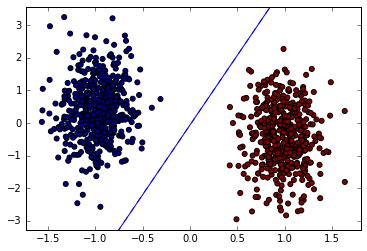

In [4]:
import hamiltonian.hmc as hmc
import hamiltonian.utils as utils
import numpy as np

mcmc=hmc.HMC(X_train,y_train,logistic.loss, logistic.grad, start_p,hyper_p, path_length=1,verbose=0)
posterior_sample,logp_samples=mcmc.multicore_sample(1e3,1e2)

par_mean={var:np.mean(posterior_sample[var],axis=0).reshape(start_p[var].shape) for var in posterior_sample.keys()}
par_var={var:np.var(posterior_sample[var],axis=0).reshape(start_p[var].shape) for var in posterior_sample.keys()}
y_pred=logistic.predict(X_test,par_mean)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plt.figure()
plt.scatter(X[:, 0], X[:, 1],marker='o', c=y,s=25, edgecolor='k')
plt.axis('tight')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

def plot_uncertainty_hyperplane(par_mean,par_var, color):
    bd = lambda x0,par :  (-(x0 * par['weights'][0]) - par['bias']) / par['weights'][1]
    r=np.linspace(xmin,xmax)
    par_m={var:par_mean[var]-np.sqrt(par_var[var]) for var in par_mean.keys()}
    par_p={var:par_mean[var]+np.sqrt(par_var[var]) for var in par_mean.keys()}
    plt.plot(r,bd(r,par_mean),ls="-", color=color)
    plt.plot(r,bd(r,par_m),ls="--", color=color, alpha=0.5)
    plt.plot(r,bd(r,par_p),ls="--", color=color, alpha=0.5)
    #plt.fill_between(r, bd(r,par_mean),  bd(r,par_p), color=color, alpha=0.5)
    #plt.fill_between(r, bd(r,par_m),  bd(r,par_mean), color=color, alpha=0.5)
    
plot_uncertainty_hyperplane(par_mean, par_var,"b")
plt.show()


step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00


  0%|          | 0/100 [00:00<?, ?it/s]

step_size 0.2500, acceptance prob: 1.00, direction : -1.00
step_size 0.2500, acceptance prob: 1.00, direction : -1.00


  0%|          | 0/100 [00:00<?, ?it/s]

step_size 0.2500, acceptance prob: 1.00, direction : 1.00


100%|██████████| 100/100 [00:00<00:00, 132.74it/s]

100%|██████████| 125/125 [00:00<00:00, 150.35it/s]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00       116
          1       1.00      1.00      1.00       134

avg / total       1.00      1.00      1.00       250

[[116   0]
 [  0 134]]


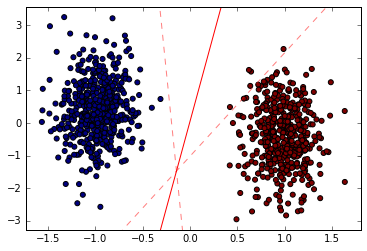

In [5]:
import hamiltonian.sghmc as sghmc_sampler

mcmc2=sghmc_sampler.SGHMC(X_train,y_train,logistic.loss, logistic.grad, start_p,hyper_p, path_length=1,verbose=0)
posterior_sample_sghmc,logp_samples_sghmc=mcmc2.multicore_sample(1e3,1e2,batch_size=50)

par_mean_sghmc={var:np.mean(posterior_sample_sghmc[var],axis=0).reshape(start_p[var].shape) for var in posterior_sample_sghmc.keys()}
par_var_sghmc={var:np.var(posterior_sample_sghmc[var],axis=0).reshape(start_p[var].shape) for var in posterior_sample_sghmc.keys()}

y_pred=logistic.predict(X_test,par_mean_sghmc)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plt.figure()
plt.scatter(X[:, 0], X[:, 1],marker='o', c=y,s=25, edgecolor='k')
plt.axis('tight')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plot_uncertainty_hyperplane(par_mean_sghmc, par_var_sghmc,"r")
plt.show()